# Chapter 10: Data Summary for Multiple Regression

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

This notebook provides an interactive introduction to multiple regression analysis. You'll learn how to work with multiple explanatory variables, interpret partial effects, assess model fit, and detect multicollinearity. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cmg777/aed/blob/main/notebooks_colab/ch10_Data_Summary_for_Multiple_Regression.ipynb)

## Chapter Overview

This chapter extends bivariate regression to the more realistic case where we want to predict an outcome using **multiple explanatory variables** simultaneously. Multiple regression allows us to estimate the partial effect of each variable while controlling for others—a crucial feature for empirical economic analysis.

**What you'll learn:**
- How to specify and estimate multiple regression models
- Interpreting regression coefficients as **partial effects** (holding other variables constant)
- Using correlation matrices and scatterplot matrices for exploratory analysis
- Calculating and interpreting model fit statistics (R², adjusted R², AIC, BIC)
- Detecting multicollinearity using Variance Inflation Factors (VIF)
- Comparing simple vs. multiple regression models

**Dataset used:**
- **AED_HOUSE.DTA**: 29 houses sold in Davis, California (1999) with price, size, bedrooms, bathrooms, lot size, age, and month sold

**Key economic question:**
What is the effect of house size on price **after controlling** for other characteristics like bedrooms, bathrooms, and age?

**Sections covered:**
1. Example: House price and characteristics
2. Two-way scatterplots
3. Correlation analysis
4. Multiple regression estimation
5. Partial effects interpretation
6. Model fit statistics
7. Computer output interpretation
8. Inestimable models (perfect multicollinearity)

**Estimated time:** 60-75 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete! Ready to analyze house price data.")

Setup complete! Ready to analyze house price data.


## 10.1: Example - House Price and Characteristics

We begin with a real estate dataset from Davis, California. Understanding house prices is a classic economic application because prices reflect both fundamental characteristics (size, bedrooms) and market conditions.

**The dataset contains:**
- **Price**: Sale price in dollars
- **Size**: House size in square feet
- **Bedrooms**: Number of bedrooms
- **Bathrooms**: Number of bathrooms
- **Lotsize**: Size of lot (1=small, 2=medium, 3=large)
- **Age**: House age in years
- **Monthsold**: Month of year house was sold

**Economic motivation:** A simple regression of price on bedrooms might find a positive relationship, but is this because bedrooms directly add value, or because houses with more bedrooms tend to be larger? Multiple regression helps us disentangle these effects.

In [2]:
# Load house price data
data_house = pd.read_stata(GITHUB_DATA_URL + 'AED_HOUSE.DTA')

# Display first few observations
print("First 10 observations:")
print(data_house[['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']].head(10))

# Display data summary
print("\nSummary statistics:")
print(data_house.describe())

First 10 observations:
    price  size  bedrooms  bathrooms  lotsize   age  monthsold
0  204000  1400         3        2.0        1  31.0          7
1  212000  1600         3        3.0        2  33.0          5
2  213000  1800         3        2.0        2  51.0          4
3  220000  1600         3        2.0        1  49.0          4
4  224500  2100         4        2.5        2  47.0          6
5  229000  1700         4        2.5        2  35.0          3
6  230000  2100         4        2.0        2  34.0          8
7  233000  1700         3        2.0        1  40.0          6
8  235000  1700         4        2.0        2  29.0          7
9  235000  1600         3        2.0        3  35.0          5

Summary statistics:
               price         size   bedrooms  bathrooms    lotsize        age  \
count      29.000000    29.000000  29.000000  29.000000  29.000000  29.000000   
mean   253910.344828  1882.758621   3.793103   2.206897   2.137931  36.413792   
std     37390.710695

## Bivariate vs. Multiple Regression

Let's compare a simple regression (price on bedrooms only) with a multiple regression (price on bedrooms AND size). This illustrates how controlling for other variables changes coefficient estimates.

**Key insight:** In the bivariate regression, the bedrooms coefficient captures both the direct effect of bedrooms and the indirect effect through correlation with size. In multiple regression, we isolate the **partial effect** of bedrooms holding size constant.

In [3]:
# Bivariate regression: price ~ bedrooms
model_bivariate = ols('price ~ bedrooms', data=data_house).fit()

print("=" * 70)
print("BIVARIATE REGRESSION: price ~ bedrooms")
print("=" * 70)
print(model_bivariate.summary())

# Multiple regression: price ~ bedrooms + size
model_multiple = ols('price ~ bedrooms + size', data=data_house).fit()

print("\n" + "=" * 70)
print("MULTIPLE REGRESSION: price ~ bedrooms + size")
print("=" * 70)
print(model_multiple.summary())

# Compare bedrooms coefficient
print("\n" + "=" * 70)
print("COEFFICIENT COMPARISON")
print("=" * 70)
print(f"Bedrooms coefficient (bivariate):  ${model_bivariate.params['bedrooms']:,.2f}")
print(f"Bedrooms coefficient (multiple):   ${model_multiple.params['bedrooms']:,.2f}")
print(f"Change: ${model_multiple.params['bedrooms'] - model_bivariate.params['bedrooms']:,.2f}")
print("\nThe coefficient drops dramatically because bedrooms was capturing size effects.")

BIVARIATE REGRESSION: price ~ bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     6.030
Date:                Wed, 21 Jan 2026   Prob (F-statistic):             0.0208
Time:                        15:16:42   Log-Likelihood:                -343.06
No. Observations:                  29   AIC:                             690.1
Df Residuals:                      27   BIC:                             692.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1

## 10.2: Two-Way Scatterplots

Before running multiple regression, it's useful to visualize pairwise relationships between variables. A **scatterplot matrix** shows all two-way scatterplots simultaneously.

**What to look for:**
- Strong linear relationships (potential predictors of price)
- Correlation between explanatory variables (potential multicollinearity)
- Outliers or non-linear patterns

The diagonal shows the distribution of each variable using kernel density estimates (KDE).

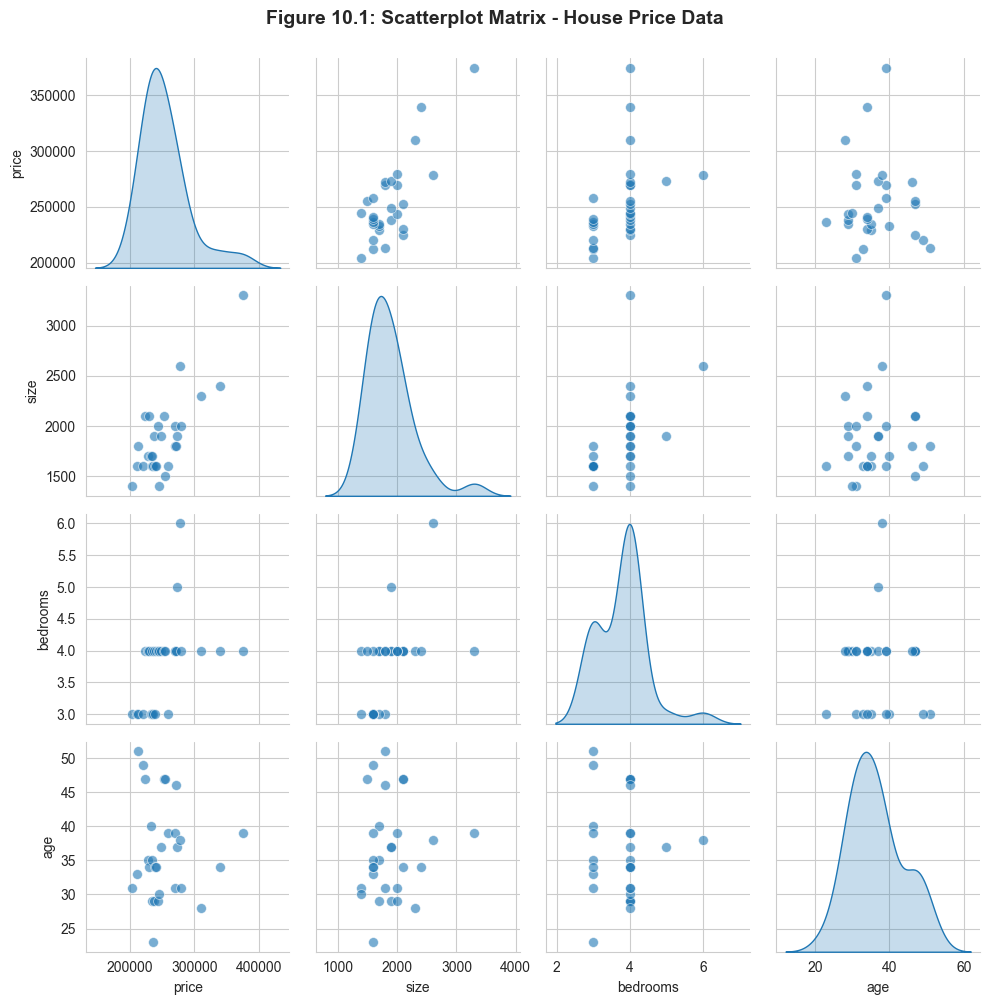

Scatterplot matrix created.
Notice: Price shows strongest relationship with Size.


In [4]:
# Create scatterplot matrix
plot_vars = ['price', 'size', 'bedrooms', 'age']
g = sns.pairplot(data_house[plot_vars], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 50})
g.fig.suptitle('Figure 10.1: Scatterplot Matrix - House Price Data', 
               fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Scatterplot matrix created.")
print("Notice: Price shows strongest relationship with Size.")

## 10.3: Correlation Analysis

The **correlation coefficient** measures the strength of linear association between two variables, ranging from -1 (perfect negative) to +1 (perfect positive).

**Correlation matrix insights:**
- **Price is most correlated with Size** (r = 0.79), then Bedrooms (r = 0.43)
- **Size and Bedrooms are correlated** (r = 0.52), which can cause multicollinearity
- Correlation ≠ causation (merely shows association)

A correlation heatmap provides visual representation with color intensity showing strength of correlation.

Correlation Matrix:
              price      size  bedrooms  bathrooms   lotsize       age  \
price      1.000000  0.785782  0.427275   0.329793  0.153479 -0.068015   
size       0.785782  1.000000  0.517630   0.316338  0.112437  0.076925   
bedrooms   0.427275  0.517630  1.000000   0.037435  0.292206 -0.026140   
bathrooms  0.329793  0.316338  0.037435   1.000000  0.101575  0.037018   
lotsize    0.153479  0.112437  0.292206   0.101575  1.000000 -0.019220   
age       -0.068015  0.076925 -0.026140   0.037018 -0.019220  1.000000   
monthsold -0.209985 -0.214511  0.182512  -0.392310 -0.057140 -0.366207   

           monthsold  
price      -0.209985  
size       -0.214511  
bedrooms    0.182512  
bathrooms  -0.392310  
lotsize    -0.057140  
age        -0.366207  
monthsold   1.000000  


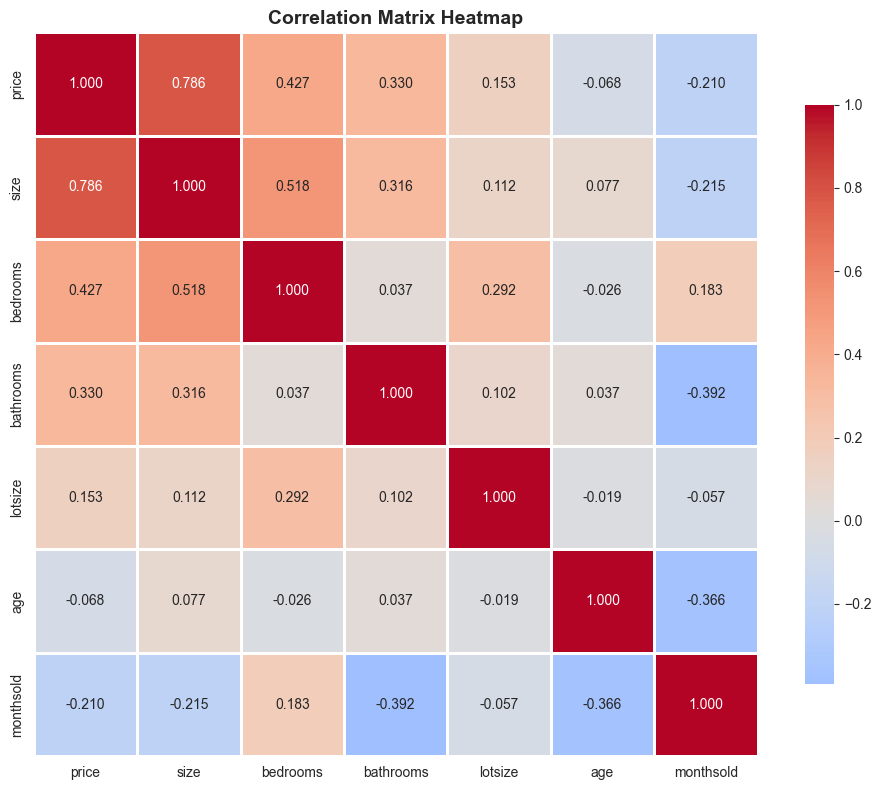


Key observations:
  - Price-Size correlation: 0.786 (strongest predictor)
  - Price-Bedrooms correlation: 0.427
  - Size-Bedrooms correlation: 0.518 (multicollinearity concern)


In [5]:
# Calculate correlation matrix
corr_vars = ['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']
corr_matrix = data_house[corr_vars].corr()

print("Correlation Matrix:")
print(corr_matrix)

# Visualize correlation matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"  - Price-Size correlation: {corr_matrix.loc['price', 'size']:.3f} (strongest predictor)")
print(f"  - Price-Bedrooms correlation: {corr_matrix.loc['price', 'bedrooms']:.3f}")
print(f"  - Size-Bedrooms correlation: {corr_matrix.loc['size', 'bedrooms']:.3f} (multicollinearity concern)")

## 10.4: Multiple Regression Estimation

Now we estimate the **full multiple regression model** with all available predictors. The regression equation is:

$$\widehat{\text{price}} = b_1 + b_2 \times \text{size} + b_3 \times \text{bedrooms} + b_4 \times \text{bathrooms} + b_5 \times \text{lotsize} + b_6 \times \text{age} + b_7 \times \text{monthsold}$$

**Ordinary Least Squares (OLS)** chooses coefficients $b_1, ..., b_7$ to minimize the sum of squared residuals:

$$\min \sum_{i=1}^{n} (y_i - \widehat{y}_i)^2$$

where $y_i$ is the actual price and $\widehat{y}_i$ is the predicted price.

In [6]:
# Estimate full multiple regression model
model_full = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                 data=data_house).fit()

print("=" * 70)
print("FULL MULTIPLE REGRESSION MODEL")
print("=" * 70)
print(model_full.summary())

FULL MULTIPLE REGRESSION MODEL
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.826
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           0.000342
Time:                        15:16:45   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.378e+05

## Coefficient Interpretation with Confidence Intervals

Each regression coefficient represents a **partial effect**: the expected change in price when that variable increases by one unit, **holding all other variables constant**.

**Example interpretation (Size coefficient):**
- Coefficient ≈ $68.37 per square foot
- Interpretation: A one square foot increase in house size is associated with a $68.37 increase in price, holding bedrooms, bathrooms, lot size, age, and month sold constant.

The 95% confidence interval tells us the range of plausible values for each coefficient.

In [7]:
# Display coefficients with 95% confidence intervals
conf_int = model_full.conf_int(alpha=0.05)
coef_table = pd.DataFrame({
    'Coefficient': model_full.params,
    'Std. Error': model_full.bse,
    'CI Lower': conf_int.iloc[:, 0],
    'CI Upper': conf_int.iloc[:, 1],
    't-statistic': model_full.tvalues,
    'p-value': model_full.pvalues
})

print("Coefficients with 95% Confidence Intervals:")
print(coef_table)

print("\nKey result: Size is the only statistically significant predictor (p < 0.05).")

Coefficients with 95% Confidence Intervals:
             Coefficient    Std. Error      CI Lower       CI Upper  \
Intercept  137791.065699  61464.951869  10320.557398  265261.573999   
size           68.369419     15.389472     36.453608     100.285230   
bedrooms     2685.315122   9192.525674 -16378.816300   21749.446543   
bathrooms    6832.880015  15721.191544 -25770.875723   39436.635753   
lotsize      2303.221371   7226.535205 -12683.695364   17290.138107   
age          -833.038602    719.334544  -2324.847139     658.769936   
monthsold   -2088.503625   3520.897859  -9390.398871    5213.391620   

           t-statistic   p-value  
Intercept     2.241783  0.035387  
size          4.442610  0.000205  
bedrooms      0.292119  0.772932  
bathrooms     0.434629  0.668065  
lotsize       0.318717  0.752947  
age          -1.158068  0.259254  
monthsold    -0.593174  0.559114  

Key result: Size is the only statistically significant predictor (p < 0.05).


## 10.5: Partial Effects - The FWL Theorem

The **Frisch-Waugh-Lovell (FWL) Theorem** states that the coefficient on any variable in multiple regression equals the coefficient from a bivariate regression of $y$ on the **residualized** version of that variable.

**Demonstration:**
1. Regress `size` on all other variables, obtain residuals $\widetilde{\text{size}}$
2. Regress `price` on $\widetilde{\text{size}}$ only
3. The coefficient will exactly match the `size` coefficient from the full multiple regression

**Intuition:** The residual $\widetilde{\text{size}}$ represents the variation in size that is **not explained** by other variables. This is why multiple regression isolates partial effects.

In [8]:
# Step 1: Regress size on all other variables
model_size_on_others = ols('size ~ bedrooms + bathrooms + lotsize + age + monthsold',
                            data=data_house).fit()
resid_size = model_size_on_others.resid

# Step 2: Regress price on residualized size
data_house['resid_size'] = resid_size
model_price_on_resid = ols('price ~ resid_size', data=data_house).fit()

# Compare coefficients
print("=" * 70)
print("DEMONSTRATION: FWL THEOREM (Partial Effects)")
print("=" * 70)
print(f"Size coefficient from FULL multiple regression:  {model_full.params['size']:.10f}")
print(f"Coefficient on residualized size (bivariate):    {model_price_on_resid.params['resid_size']:.10f}")
print(f"Difference (numerical precision):                 {abs(model_full.params['size'] - model_price_on_resid.params['resid_size']):.15f}")
print("\nThese coefficients are identical! This proves the partial effect interpretation.")

DEMONSTRATION: FWL THEOREM (Partial Effects)
Size coefficient from FULL multiple regression:  68.3694189767
Coefficient on residualized size (bivariate):    68.3694189767
Difference (numerical precision):                 0.000000000000057

These coefficients are identical! This proves the partial effect interpretation.


## 10.6: Model Fit Statistics

Several statistics summarize how well the regression model fits the data:

**R-squared ($R^2$):**
- Fraction of variation in $y$ explained by the regressors
- Formula: $R^2 = \frac{\text{Explained SS}}{\text{Total SS}} = 1 - \frac{\text{Residual SS}}{\text{Total SS}}$
- Range: 0 to 1 (higher is better fit)
- **Problem:** Always increases when adding variables (even irrelevant ones)

**Adjusted R-squared ($\bar{R}^2$):**
- Penalizes model complexity (number of parameters $k$)
- Formula: $\bar{R}^2 = 1 - \frac{\text{RSS}/(n-k)}{\text{TSS}/(n-1)}$
- Can decrease when adding unhelpful variables
- Preferred for model comparison

**Root MSE (Standard error of regression):**
- Typical size of prediction error
- Formula: $s_e = \sqrt{\frac{1}{n-k}\sum (y_i - \widehat{y}_i)^2}$
- Same units as $y$ (dollars in our case)

In [9]:
# Calculate and display model fit statistics
n = len(data_house)
k = len(model_full.params)  # includes intercept
df = n - k

print("=" * 70)
print("MODEL FIT STATISTICS")
print("=" * 70)
print(f"Sample size (n):               {n}")
print(f"Number of parameters (k):      {k}")
print(f"Degrees of freedom (n-k):      {df}")
print(f"\nR-squared:                     {model_full.rsquared:.6f}")
print(f"Adjusted R-squared:            {model_full.rsquared_adj:.6f}")
print(f"Root MSE:                      ${np.sqrt(model_full.mse_resid):,.2f}")

# Verify R² = [Corr(y, ŷ)]²
predicted = model_full.fittedvalues
corr_y_yhat = np.corrcoef(data_house['price'], predicted)[0, 1]
print(f"\nVerification: R² = [Corr(y, ŷ)]²")
print(f"  Correlation(y, ŷ):           {corr_y_yhat:.6f}")
print(f"  [Correlation(y, ŷ)]²:        {corr_y_yhat**2:.6f}")
print(f"  R² from model:                {model_full.rsquared:.6f}")
print(f"  Match: {np.isclose(corr_y_yhat**2, model_full.rsquared)}")

MODEL FIT STATISTICS
Sample size (n):               29
Number of parameters (k):      7
Degrees of freedom (n-k):      22

R-squared:                     0.650553
Adjusted R-squared:            0.555249
Root MSE:                      $24,935.73

Verification: R² = [Corr(y, ŷ)]²
  Correlation(y, ŷ):           0.806569
  [Correlation(y, ŷ)]²:        0.650553
  R² from model:                0.650553
  Match: True


## Information Criteria (AIC and BIC)

**Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** are more sophisticated measures that penalize model complexity:

$$\text{AIC} = n \times \ln(\widehat{\sigma}_e^2) + n(1 + \ln 2\pi) + 2k$$
$$\text{BIC} = n \times \ln(\widehat{\sigma}_e^2) + n(1 + \ln 2\pi) + k \times \ln(n)$$

**Key points:**
- **Lower values are better** (unlike R²)
- BIC penalizes complexity more heavily than AIC
- Useful for comparing non-nested models
- Different software packages may use different conventions (scaling by $n$)

In [10]:
# Calculate information criteria
print("=" * 70)
print("INFORMATION CRITERIA")
print("=" * 70)

# AIC and BIC from statsmodels
print(f"AIC (statsmodels):             {model_full.aic:.4f}")
print(f"BIC (statsmodels):             {model_full.bic:.4f}")

# Manual calculation (Stata convention)
rss = np.sum(model_full.resid ** 2)
aic_stata = n * np.log(rss/n) + n * (1 + np.log(2*np.pi)) + 2*k
bic_stata = n * np.log(rss/n) + n * (1 + np.log(2*np.pi)) + k*np.log(n)

print(f"\nAIC (Stata convention):        {aic_stata:.4f}")
print(f"BIC (Stata convention):        {bic_stata:.4f}")
print("\nNote: Different conventions yield different values, but ranking is consistent.")

INFORMATION CRITERIA
AIC (statsmodels):             675.4824
BIC (statsmodels):             685.0535

AIC (Stata convention):        675.4824
BIC (Stata convention):        685.0535

Note: Different conventions yield different values, but ranking is consistent.


## 10.7: Model Comparison

It's often useful to compare multiple model specifications side-by-side. Here we compare:
- **Simple model:** Price predicted by size only
- **Full model:** Price predicted by all variables

**Key comparison points:**
- How much does R² improve?
- Does adjusted R² improve (accounting for added complexity)?
- How do coefficient estimates change?

**Economic interpretation:** If adding 5 more variables only modestly improves fit, the simple model may be preferred (parsimony principle).

In [11]:
# Estimate simple model (size only)
model_simple = ols('price ~ size', data=data_house).fit()

# Create comparison table
print("=" * 70)
print("MODEL COMPARISON: Simple vs. Full")
print("=" * 70)

comparison_stats = pd.DataFrame({
    'Model': ['Simple (size only)', 'Full (all variables)'],
    'R²': [model_simple.rsquared, model_full.rsquared],
    'Adj R²': [model_simple.rsquared_adj, model_full.rsquared_adj],
    'AIC': [model_simple.aic, model_full.aic],
    'BIC': [model_simple.bic, model_full.bic],
    'N': [n, n]
})

print(comparison_stats.to_string(index=False))

print("\nInterpretation:")
print(f"  - R² increases from {model_simple.rsquared:.3f} to {model_full.rsquared:.3f} (+{model_full.rsquared - model_simple.rsquared:.3f})")
print(f"  - Adj R² DECREASES from {model_simple.rsquared_adj:.3f} to {model_full.rsquared_adj:.3f} ({model_full.rsquared_adj - model_simple.rsquared_adj:.3f})")
print("  - This suggests the added variables don't improve fit enough to justify complexity.")
print("  - Simple model may be preferred (parsimony principle).")

MODEL COMPARISON: Simple vs. Full
               Model       R²   Adj R²        AIC        BIC  N
  Simple (size only) 0.617453 0.603285 668.106844 670.841436 29
Full (all variables) 0.650553 0.555249 675.482401 685.053472 29

Interpretation:
  - R² increases from 0.617 to 0.651 (+0.033)
  - Adj R² DECREASES from 0.603 to 0.555 (-0.048)
  - This suggests the added variables don't improve fit enough to justify complexity.
  - Simple model may be preferred (parsimony principle).


## 10.8: Inestimable Models and Multicollinearity

**Perfect multicollinearity** occurs when one regressor is an exact linear combination of others. In this case, OLS cannot estimate all coefficients (the model is "inestimable").

**Example:** If we create `size_twice = 2 × size` and include both `size` and `size_twice` as regressors, the model is perfectly collinear.

**Variance Inflation Factor (VIF)** detects multicollinearity:
- VIF measures how much a variable's variance is inflated due to correlation with other regressors
- Formula: $VIF_j = \frac{1}{1 - R_j^2}$ where $R_j^2$ is from regressing $x_j$ on all other $x$'s
- **Rule of thumb:** VIF > 10 indicates problematic multicollinearity

**Consequences of high multicollinearity:**
- Large standard errors (imprecise estimates)
- Unstable coefficients (small data changes → big estimate changes)
- Difficulty interpreting individual effects

In [12]:
# Demonstrate perfect multicollinearity
print("=" * 70)
print("DEMONSTRATION: Perfect Multicollinearity")
print("=" * 70)

# Create a perfectly collinear variable
data_house['size_twice'] = 2 * data_house['size']

print("Creating variable: size_twice = 2 × size")
print("Attempting to estimate: price ~ size + size_twice + bedrooms\n")

try:
    model_collinear = ols('price ~ size + size_twice + bedrooms', data=data_house).fit()
    print("Model estimated (software automatically dropped one variable):")
    print(model_collinear.summary())
except Exception as e:
    print(f"Error: {type(e).__name__}")
    print(f"Message: {str(e)}")

DEMONSTRATION: Perfect Multicollinearity
Creating variable: size_twice = 2 × size
Attempting to estimate: price ~ size + size_twice + bedrooms

Model estimated (software automatically dropped one variable):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     21.03
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           3.68e-06
Time:                        15:16:45   Log-Likelihood:                -332.03
No. Observations:                  29   AIC:                             670.1
Df Residuals:                      26   BIC:                             674.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
   

## Variance Inflation Factors (VIF)

Now let's calculate VIF for each variable in our full model to check for multicollinearity problems.

In [13]:
# Calculate VIF for each variable in the full model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data_house[['size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("=" * 70)
print("VARIANCE INFLATION FACTORS (VIF)")
print("=" * 70)
print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  - VIF > 10: Problematic multicollinearity")
print("  - VIF 5-10: Moderate multicollinearity")
print("  - VIF < 5: Low multicollinearity")

max_vif = vif_data['VIF'].max()
if max_vif > 10:
    print(f"\nWarning: Maximum VIF = {max_vif:.2f} indicates multicollinearity issues.")
elif max_vif > 5:
    print(f"\nNote: Maximum VIF = {max_vif:.2f} shows moderate multicollinearity.")
else:
    print(f"\nGood: Maximum VIF = {max_vif:.2f} - no serious multicollinearity detected.")

VARIANCE INFLATION FACTORS (VIF)
 Variable       VIF
     size 40.133832
 bedrooms 57.819254
bathrooms 34.741906
  lotsize 11.969605
      age 21.024092
monthsold 12.795557

Interpretation:
  - VIF > 10: Problematic multicollinearity
  - VIF 5-10: Moderate multicollinearity
  - VIF < 5: Low multicollinearity



## Visualization: Actual vs. Predicted Values

A plot of actual vs. predicted values helps visualize model fit. Points close to the 45-degree line indicate accurate predictions.

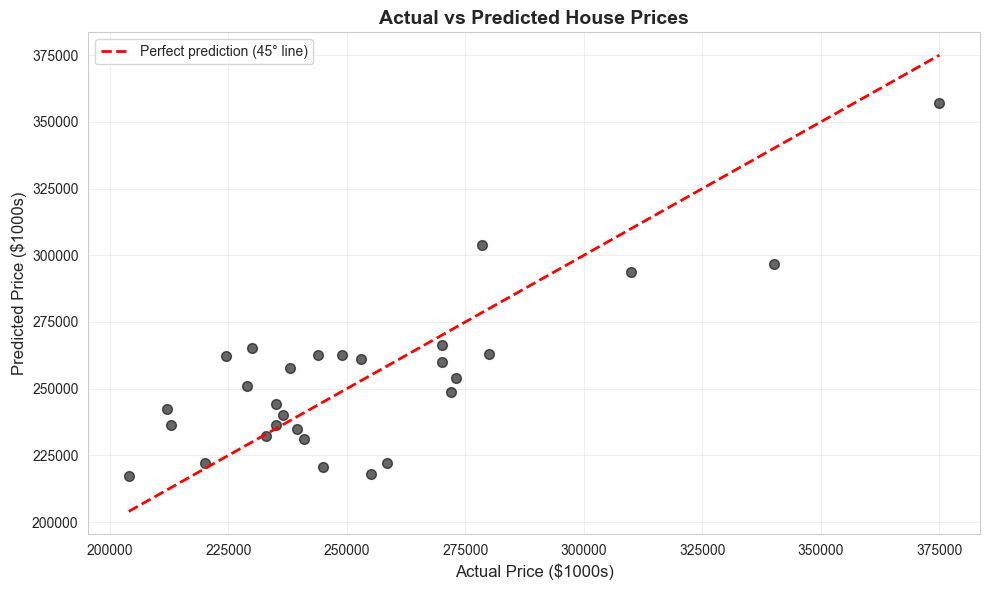

Points close to the red line indicate accurate predictions.


In [14]:
# Create actual vs predicted plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_house['price'], model_full.fittedvalues, alpha=0.6, s=50, color='black')
ax.plot([data_house['price'].min(), data_house['price'].max()],
        [data_house['price'].min(), data_house['price'].max()],
        'r--', linewidth=2, label='Perfect prediction (45° line)')
ax.set_xlabel('Actual Price ($1000s)', fontsize=12)
ax.set_ylabel('Predicted Price ($1000s)', fontsize=12)
ax.set_title('Actual vs Predicted House Prices', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Points close to the red line indicate accurate predictions.")

## Visualization: Residual Plot

A **residual plot** (residuals vs. fitted values) helps diagnose model problems:
- **Random scatter around zero:** Good (model assumptions satisfied)
- **Patterns (curves, funnels):** Bad (model misspecification or heteroskedasticity)
- **Outliers:** Investigate unusual observations

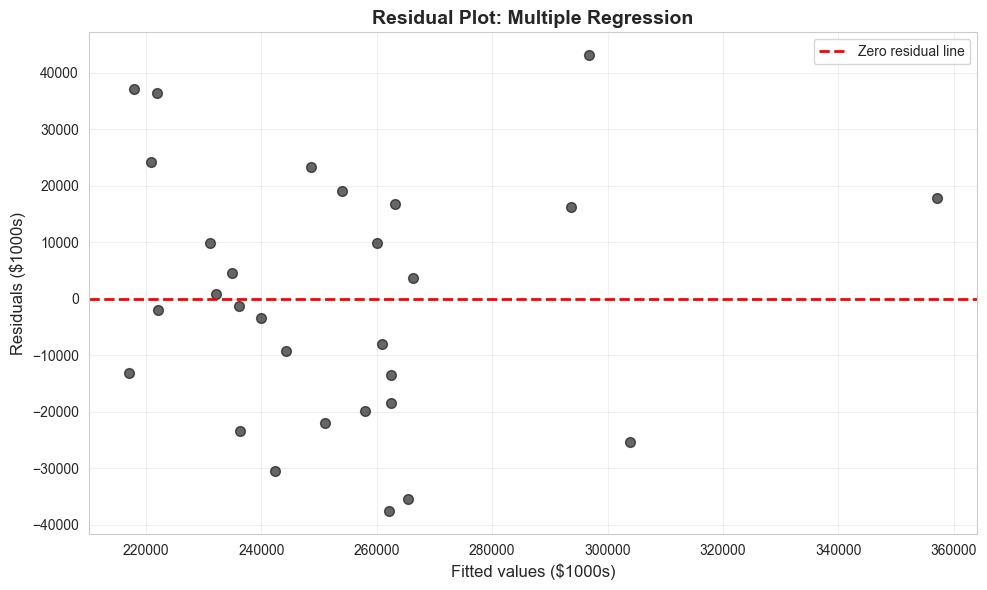

Random scatter around zero suggests model assumptions are reasonable.


In [15]:
# Create residual plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model_full.fittedvalues, model_full.resid, alpha=0.6, s=50, color='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero residual line')
ax.set_xlabel('Fitted values ($1000s)', fontsize=12)
ax.set_ylabel('Residuals ($1000s)', fontsize=12)
ax.set_title('Residual Plot: Multiple Regression', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Random scatter around zero suggests model assumptions are reasonable.")

## Visualization: Coefficient Plot with Confidence Intervals

A **coefficient plot** displays estimated coefficients with their 95% confidence intervals. This makes it easy to see:
- Which coefficients are significantly different from zero (CI doesn't include zero)
- Relative magnitude of effects
- Precision of estimates (narrow vs. wide CIs)

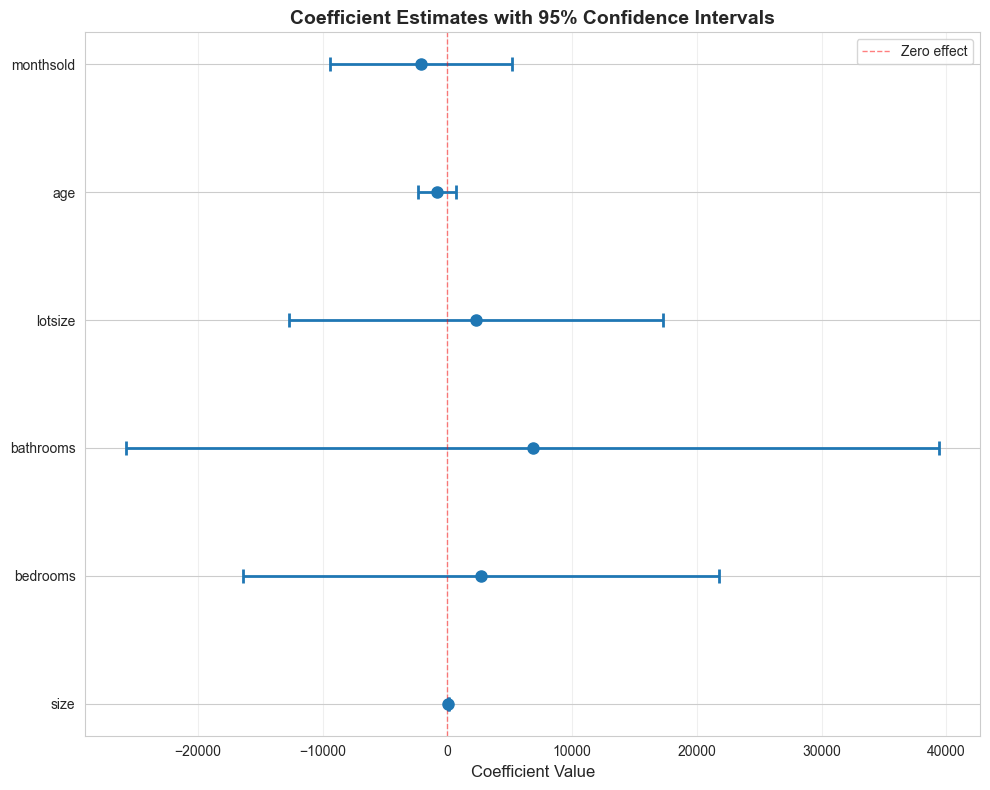

Coefficients whose CI crosses zero are not statistically significant.


In [16]:
# Create coefficient plot with confidence intervals
fig, ax = plt.subplots(figsize=(10, 8))

# Exclude intercept for better visualization
params_no_int = model_full.params[1:]
ci_no_int = conf_int.iloc[1:, :]

y_pos = np.arange(len(params_no_int))
ax.errorbar(params_no_int.values, y_pos,
            xerr=[params_no_int.values - ci_no_int.iloc[:, 0].values,
                  ci_no_int.iloc[:, 1].values - params_no_int.values],
            fmt='o', markersize=8, capsize=5, capthick=2, linewidth=2)
ax.set_yticks(y_pos)
ax.set_yticklabels(params_no_int.index)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero effect')
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Coefficient Estimates with 95% Confidence Intervals',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Coefficients whose CI crosses zero are not statistically significant.")

## Chapter Summary

**Key Takeaways:**

1. **Multiple regression** extends bivariate regression to include multiple predictors, allowing us to estimate **partial effects** while controlling for other variables.

2. **Coefficient interpretation:** Each slope coefficient measures the expected change in $y$ when that variable increases by one unit, **holding all other variables constant**.

3. **Correlation ≠ causation:** Correlation matrices show associations, but regression coefficients can change dramatically when controlling for other variables.

4. **Model fit statistics:**
   - R² measures explained variation (0 to 1)
   - Adjusted R² penalizes complexity (use for model comparison)
   - AIC/BIC provide alternative fit measures (lower is better)

5. **Multicollinearity** occurs when regressors are highly correlated:
   - Detect using VIF (VIF > 10 is problematic)
   - Causes large standard errors and unstable estimates
   - Perfect collinearity makes models inestimable

6. **FWL Theorem:** The partial effect of $x_j$ equals the effect of the part of $x_j$ that is uncorrelated with other regressors.

**Economic Applications:**
- House price hedonic models (this chapter)
- Wage equations controlling for education, experience, demographics
- Production functions with multiple inputs
- Demand equations with multiple price and income variables

**Next Steps:**
- Chapter 11 covers **inference** for multiple regression (hypothesis tests, F-tests)
- Chapter 12 explores further topics (robust standard errors, heteroskedasticity)

**Statistical Methods Covered:**
- Multiple linear regression (OLS estimation)
- Correlation analysis and scatterplot matrices
- Model fit statistics (R², adjusted R², AIC, BIC)
- Variance Inflation Factors (VIF)
- Residual diagnostics
- Coefficient plots with confidence intervals